Found 700 validated image filenames.
Found 700 validated image filenames.
Found 456 validated image filenames.
Epoch 1/60
35/35 [==============================] - 260s 7s/step - loss: 0.0758 - mean_absolute_error: 0.1990 - val_loss: 0.0638 - val_mean_absolute_error: 0.1550

Epoch 00001: val_mean_absolute_error improved from inf to 0.15502, saving model to meat_best.h5


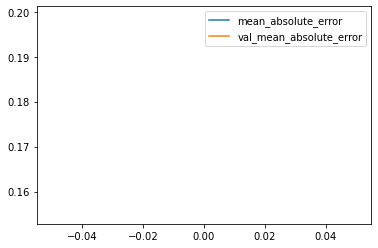

Epoch 2/60
35/35 [==============================] - 261s 7s/step - loss: 0.0440 - mean_absolute_error: 0.1403 - val_loss: 0.0594 - val_mean_absolute_error: 0.1516

Epoch 00002: val_mean_absolute_error improved from 0.15502 to 0.15161, saving model to meat_best.h5


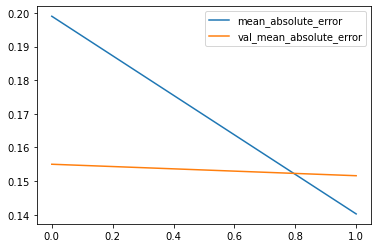

Epoch 3/60
35/35 [==============================] - 259s 7s/step - loss: 0.0404 - mean_absolute_error: 0.1405 - val_loss: 0.0621 - val_mean_absolute_error: 0.1537

Epoch 00003: val_mean_absolute_error did not improve from 0.15161


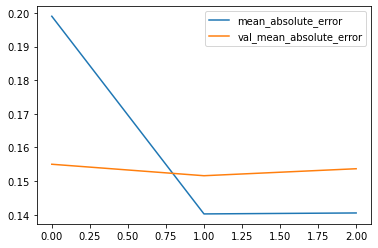

Epoch 4/60
35/35 [==============================] - 284s 8s/step - loss: 0.0373 - mean_absolute_error: 0.1317 - val_loss: 0.0615 - val_mean_absolute_error: 0.1532

Epoch 00004: val_mean_absolute_error did not improve from 0.15161


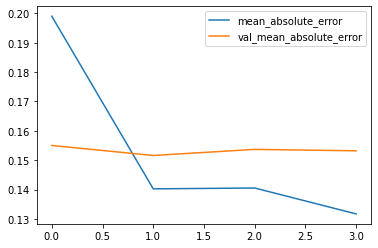

Epoch 5/60
35/35 [==============================] - 257s 7s/step - loss: 0.0352 - mean_absolute_error: 0.1312 - val_loss: 0.0554 - val_mean_absolute_error: 0.1506

Epoch 00005: val_mean_absolute_error improved from 0.15161 to 0.15056, saving model to meat_best.h5


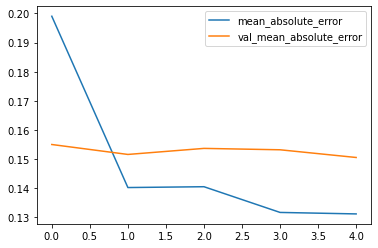

Epoch 6/60
35/35 [==============================] - 261s 7s/step - loss: 0.0321 - mean_absolute_error: 0.1244 - val_loss: 0.0523 - val_mean_absolute_error: 0.1513

Epoch 00006: val_mean_absolute_error did not improve from 0.15056


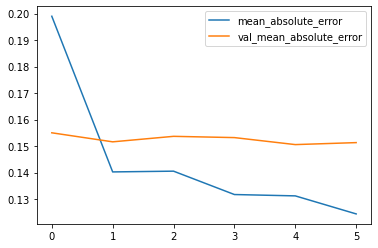

Epoch 7/60
35/35 [==============================] - 257s 7s/step - loss: 0.0290 - mean_absolute_error: 0.1207 - val_loss: 0.0612 - val_mean_absolute_error: 0.1528

Epoch 00007: val_mean_absolute_error did not improve from 0.15056


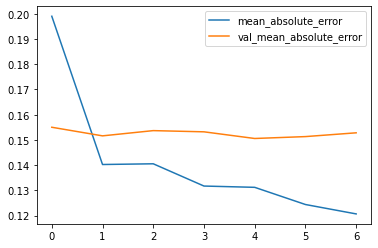

Epoch 8/60
35/35 [==============================] - 260s 7s/step - loss: 0.0293 - mean_absolute_error: 0.1231 - val_loss: 0.0583 - val_mean_absolute_error: 0.1522

Epoch 00008: val_mean_absolute_error did not improve from 0.15056


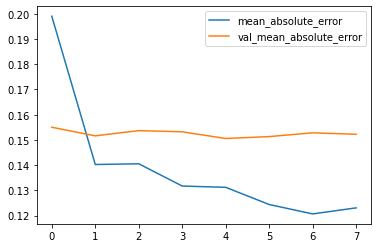

Epoch 9/60
35/35 [==============================] - 258s 7s/step - loss: 0.0250 - mean_absolute_error: 0.1171 - val_loss: 0.0647 - val_mean_absolute_error: 0.1562

Epoch 00009: val_mean_absolute_error did not improve from 0.15056


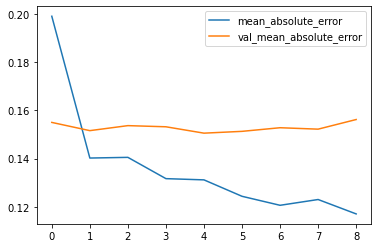

Epoch 10/60
35/35 [==============================] - 261s 7s/step - loss: 0.0224 - mean_absolute_error: 0.1091 - val_loss: 0.0574 - val_mean_absolute_error: 0.1525

Epoch 00010: val_mean_absolute_error did not improve from 0.15056


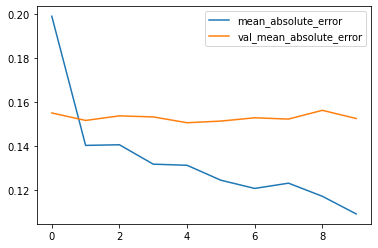

Epoch 11/60
35/35 [==============================] - 262s 8s/step - loss: 0.0220 - mean_absolute_error: 0.1068 - val_loss: 0.0637 - val_mean_absolute_error: 0.1549

Epoch 00011: val_mean_absolute_error did not improve from 0.15056


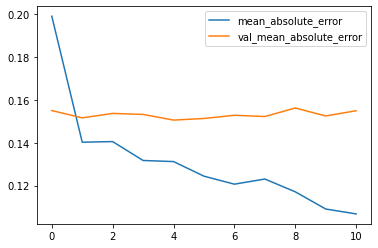

Epoch 12/60
35/35 [==============================] - 263s 8s/step - loss: 0.0252 - mean_absolute_error: 0.1141 - val_loss: 0.0676 - val_mean_absolute_error: 0.1589

Epoch 00012: val_mean_absolute_error did not improve from 0.15056


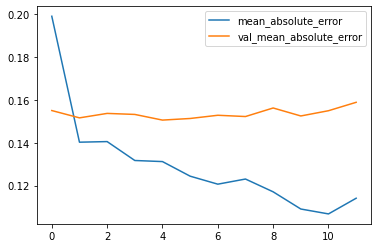

Epoch 13/60
35/35 [==============================] - 261s 7s/step - loss: 0.0254 - mean_absolute_error: 0.1111 - val_loss: 0.0602 - val_mean_absolute_error: 0.1540

Epoch 00013: val_mean_absolute_error did not improve from 0.15056


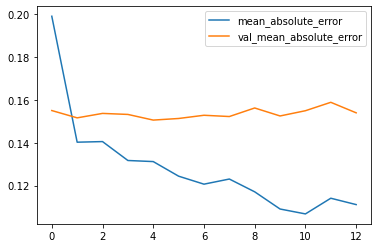

Epoch 14/60
35/35 [==============================] - 260s 7s/step - loss: 0.0215 - mean_absolute_error: 0.1085 - val_loss: 0.0633 - val_mean_absolute_error: 0.1583

Epoch 00014: val_mean_absolute_error did not improve from 0.15056


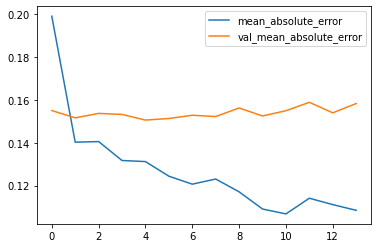

Epoch 15/60
35/35 [==============================] - 257s 7s/step - loss: 0.0217 - mean_absolute_error: 0.1054 - val_loss: 0.0637 - val_mean_absolute_error: 0.1551

Epoch 00015: val_mean_absolute_error did not improve from 0.15056


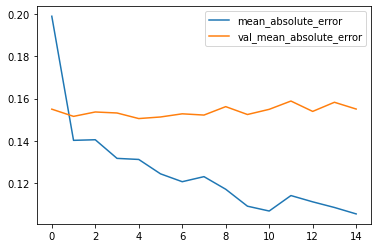

Epoch 16/60
35/35 [==============================] - 258s 7s/step - loss: 0.0276 - mean_absolute_error: 0.1164 - val_loss: 0.0498 - val_mean_absolute_error: 0.1425

Epoch 00016: val_mean_absolute_error improved from 0.15056 to 0.14250, saving model to meat_best.h5


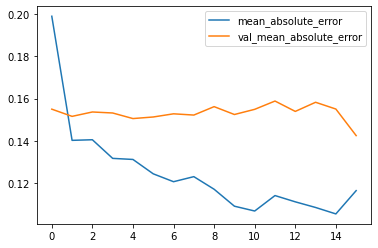

Epoch 17/60
35/35 [==============================] - 260s 7s/step - loss: 0.0225 - mean_absolute_error: 0.1090 - val_loss: 0.0245 - val_mean_absolute_error: 0.1084

Epoch 00017: val_mean_absolute_error improved from 0.14250 to 0.10836, saving model to meat_best.h5


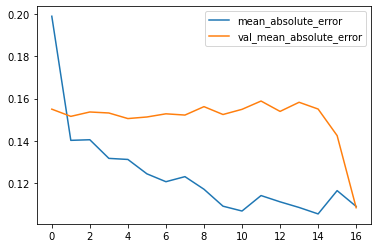

Epoch 18/60
35/35 [==============================] - 260s 7s/step - loss: 0.0216 - mean_absolute_error: 0.1061 - val_loss: 0.0365 - val_mean_absolute_error: 0.1248

Epoch 00018: val_mean_absolute_error did not improve from 0.10836


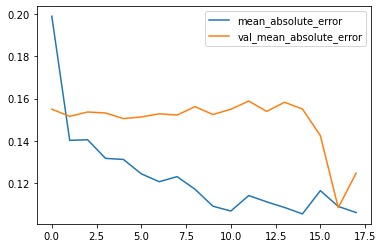

Epoch 19/60
35/35 [==============================] - 260s 7s/step - loss: 0.0219 - mean_absolute_error: 0.1074 - val_loss: 0.0329 - val_mean_absolute_error: 0.1231

Epoch 00019: val_mean_absolute_error did not improve from 0.10836


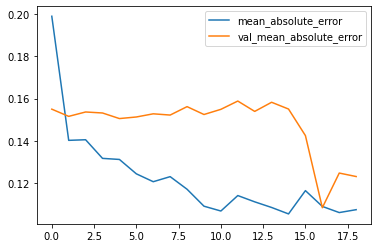

Epoch 20/60
35/35 [==============================] - 260s 7s/step - loss: 0.0187 - mean_absolute_error: 0.1010 - val_loss: 0.0180 - val_mean_absolute_error: 0.0973

Epoch 00020: val_mean_absolute_error improved from 0.10836 to 0.09730, saving model to meat_best.h5


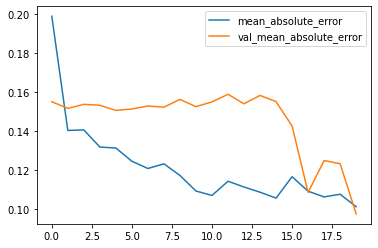

Epoch 21/60
35/35 [==============================] - 261s 7s/step - loss: 0.0210 - mean_absolute_error: 0.1059 - val_loss: 0.0183 - val_mean_absolute_error: 0.0955

Epoch 00021: val_mean_absolute_error improved from 0.09730 to 0.09549, saving model to meat_best.h5


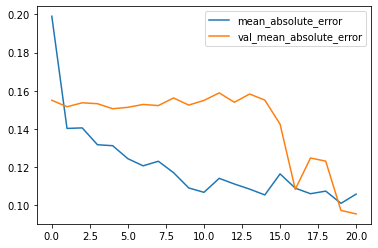

Epoch 22/60
35/35 [==============================] - 256s 7s/step - loss: 0.0177 - mean_absolute_error: 0.0976 - val_loss: 0.0228 - val_mean_absolute_error: 0.1012

Epoch 00022: val_mean_absolute_error did not improve from 0.09549


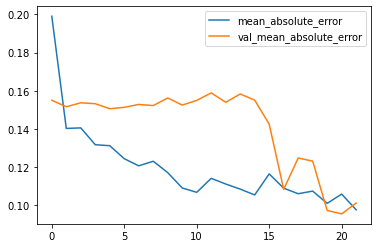

Epoch 23/60
35/35 [==============================] - 258s 7s/step - loss: 0.0220 - mean_absolute_error: 0.1057 - val_loss: 0.0253 - val_mean_absolute_error: 0.1137

Epoch 00023: val_mean_absolute_error did not improve from 0.09549


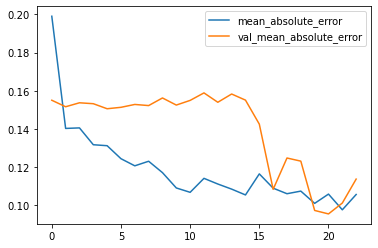

Epoch 24/60
35/35 [==============================] - 258s 7s/step - loss: 0.0201 - mean_absolute_error: 0.1019 - val_loss: 0.0199 - val_mean_absolute_error: 0.1000

Epoch 00024: val_mean_absolute_error did not improve from 0.09549


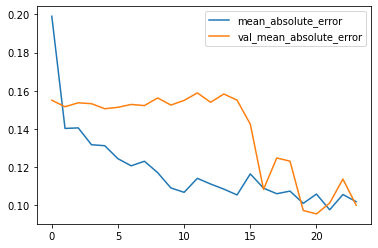

Epoch 25/60
35/35 [==============================] - 257s 7s/step - loss: 0.0176 - mean_absolute_error: 0.1007 - val_loss: 0.0181 - val_mean_absolute_error: 0.0963

Epoch 00025: val_mean_absolute_error did not improve from 0.09549


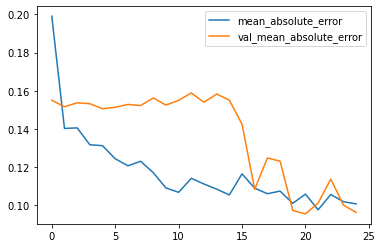

Epoch 26/60
35/35 [==============================] - 259s 7s/step - loss: 0.0193 - mean_absolute_error: 0.1019 - val_loss: 0.0202 - val_mean_absolute_error: 0.0985

Epoch 00026: val_mean_absolute_error did not improve from 0.09549


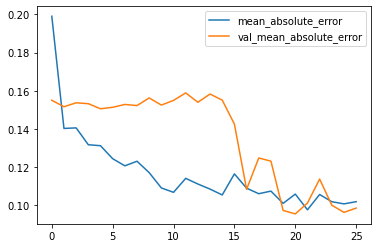

Epoch 27/60
35/35 [==============================] - 258s 7s/step - loss: 0.0178 - mean_absolute_error: 0.0974 - val_loss: 0.0306 - val_mean_absolute_error: 0.1144

Epoch 00027: val_mean_absolute_error did not improve from 0.09549


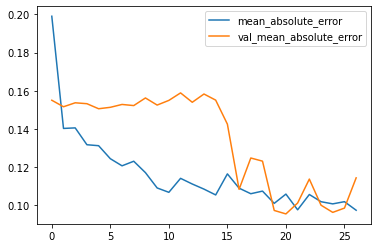

Epoch 28/60
35/35 [==============================] - 260s 7s/step - loss: 0.0177 - mean_absolute_error: 0.0984 - val_loss: 0.0258 - val_mean_absolute_error: 0.1099

Epoch 00028: val_mean_absolute_error did not improve from 0.09549


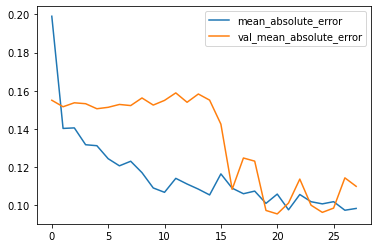

Epoch 29/60
35/35 [==============================] - 261s 7s/step - loss: 0.0178 - mean_absolute_error: 0.0980 - val_loss: 0.0202 - val_mean_absolute_error: 0.0988

Epoch 00029: val_mean_absolute_error did not improve from 0.09549


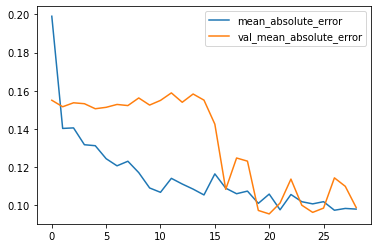

Epoch 30/60
35/35 [==============================] - 257s 7s/step - loss: 0.0186 - mean_absolute_error: 0.1003 - val_loss: 0.0161 - val_mean_absolute_error: 0.0937

Epoch 00030: val_mean_absolute_error improved from 0.09549 to 0.09371, saving model to meat_best.h5


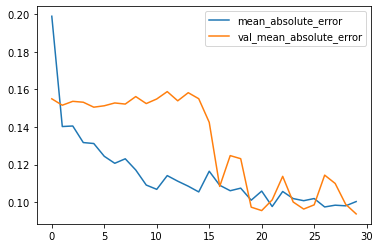

Epoch 31/60
35/35 [==============================] - 261s 7s/step - loss: 0.0156 - mean_absolute_error: 0.0938 - val_loss: 0.0159 - val_mean_absolute_error: 0.0913

Epoch 00031: val_mean_absolute_error improved from 0.09371 to 0.09130, saving model to meat_best.h5


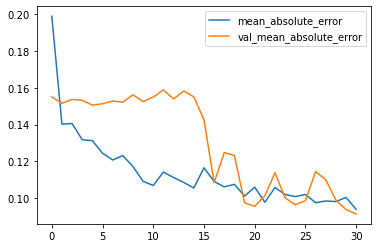

Epoch 32/60
35/35 [==============================] - 259s 7s/step - loss: 0.0167 - mean_absolute_error: 0.0929 - val_loss: 0.0542 - val_mean_absolute_error: 0.1569

Epoch 00032: val_mean_absolute_error did not improve from 0.09130


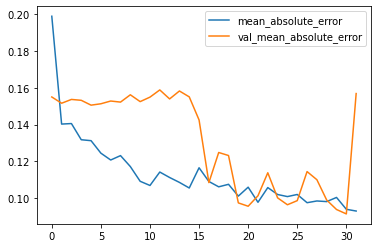

Epoch 33/60
35/35 [==============================] - 258s 7s/step - loss: 0.0167 - mean_absolute_error: 0.0965 - val_loss: 0.0225 - val_mean_absolute_error: 0.1038

Epoch 00033: val_mean_absolute_error did not improve from 0.09130


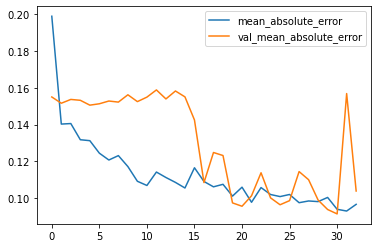

Epoch 34/60
35/35 [==============================] - 258s 7s/step - loss: 0.0170 - mean_absolute_error: 0.0957 - val_loss: 0.0193 - val_mean_absolute_error: 0.0953

Epoch 00034: val_mean_absolute_error did not improve from 0.09130


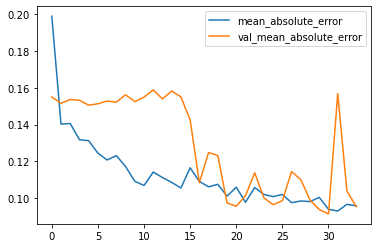

Epoch 35/60
35/35 [==============================] - 260s 7s/step - loss: 0.0146 - mean_absolute_error: 0.0905 - val_loss: 0.0155 - val_mean_absolute_error: 0.0902

Epoch 00035: val_mean_absolute_error improved from 0.09130 to 0.09018, saving model to meat_best.h5


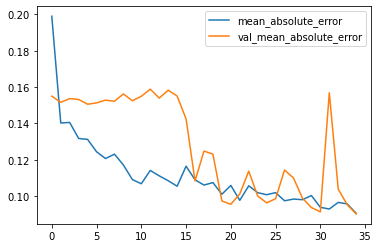

Epoch 36/60
35/35 [==============================] - 258s 7s/step - loss: 0.0144 - mean_absolute_error: 0.0883 - val_loss: 0.0181 - val_mean_absolute_error: 0.0959

Epoch 00036: val_mean_absolute_error did not improve from 0.09018


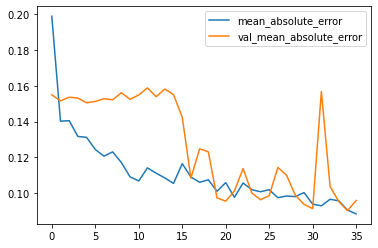

Epoch 37/60
35/35 [==============================] - 258s 7s/step - loss: 0.0170 - mean_absolute_error: 0.0951 - val_loss: 0.0171 - val_mean_absolute_error: 0.0935

Epoch 00037: val_mean_absolute_error did not improve from 0.09018


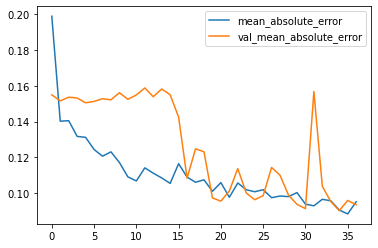

Epoch 38/60
35/35 [==============================] - 259s 7s/step - loss: 0.0143 - mean_absolute_error: 0.0870 - val_loss: 0.0144 - val_mean_absolute_error: 0.0867

Epoch 00038: val_mean_absolute_error improved from 0.09018 to 0.08668, saving model to meat_best.h5


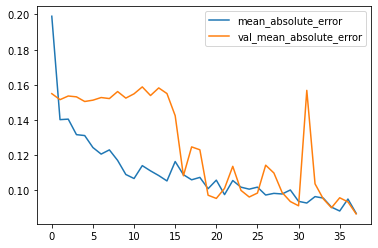

Epoch 39/60
35/35 [==============================] - 263s 8s/step - loss: 0.0158 - mean_absolute_error: 0.0945 - val_loss: 0.0168 - val_mean_absolute_error: 0.0912

Epoch 00039: val_mean_absolute_error did not improve from 0.08668


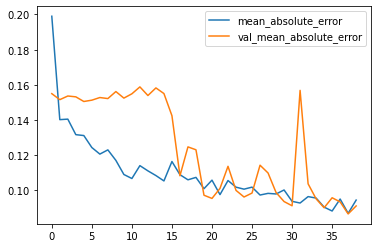

Epoch 40/60
35/35 [==============================] - 259s 7s/step - loss: 0.0164 - mean_absolute_error: 0.0920 - val_loss: 0.0252 - val_mean_absolute_error: 0.1122

Epoch 00040: val_mean_absolute_error did not improve from 0.08668


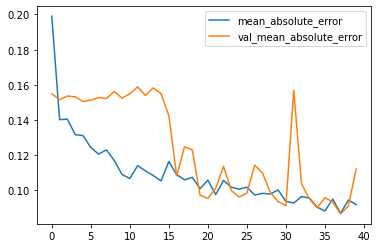

Epoch 41/60
35/35 [==============================] - 261s 7s/step - loss: 0.0162 - mean_absolute_error: 0.0936 - val_loss: 0.0212 - val_mean_absolute_error: 0.1016

Epoch 00041: val_mean_absolute_error did not improve from 0.08668


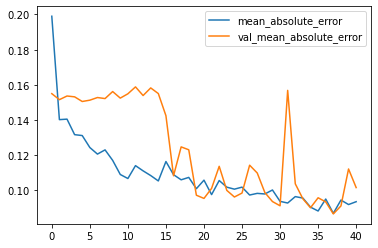

Epoch 42/60
35/35 [==============================] - 261s 7s/step - loss: 0.0149 - mean_absolute_error: 0.0892 - val_loss: 0.0202 - val_mean_absolute_error: 0.0963

Epoch 00042: val_mean_absolute_error did not improve from 0.08668


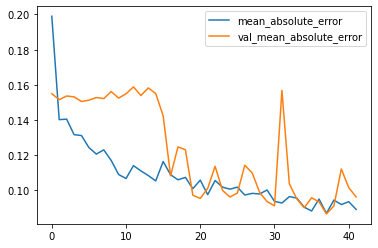

Epoch 43/60
35/35 [==============================] - 261s 7s/step - loss: 0.0150 - mean_absolute_error: 0.0912 - val_loss: 0.0123 - val_mean_absolute_error: 0.0814

Epoch 00043: val_mean_absolute_error improved from 0.08668 to 0.08140, saving model to meat_best.h5


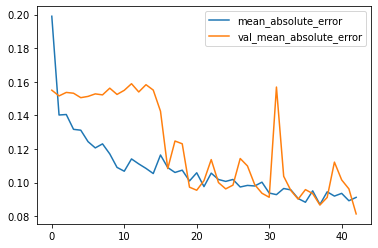

Epoch 44/60
35/35 [==============================] - 259s 7s/step - loss: 0.0139 - mean_absolute_error: 0.0858 - val_loss: 0.0140 - val_mean_absolute_error: 0.0842

Epoch 00044: val_mean_absolute_error did not improve from 0.08140


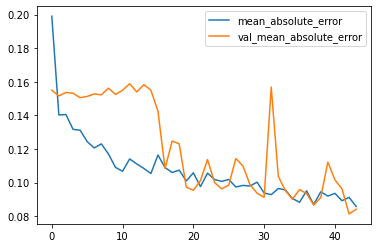

Epoch 45/60
35/35 [==============================] - 256s 7s/step - loss: 0.0132 - mean_absolute_error: 0.0856 - val_loss: 0.0326 - val_mean_absolute_error: 0.1184

Epoch 00045: val_mean_absolute_error did not improve from 0.08140


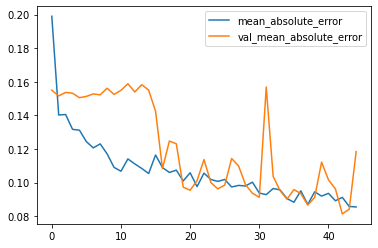

Epoch 46/60
35/35 [==============================] - 258s 7s/step - loss: 0.0126 - mean_absolute_error: 0.0842 - val_loss: 0.0116 - val_mean_absolute_error: 0.0774

Epoch 00046: val_mean_absolute_error improved from 0.08140 to 0.07744, saving model to meat_best.h5


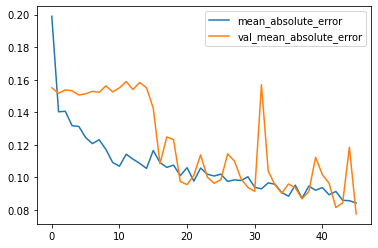

Epoch 47/60
35/35 [==============================] - 257s 7s/step - loss: 0.0121 - mean_absolute_error: 0.0812 - val_loss: 0.0175 - val_mean_absolute_error: 0.0954

Epoch 00047: val_mean_absolute_error did not improve from 0.07744


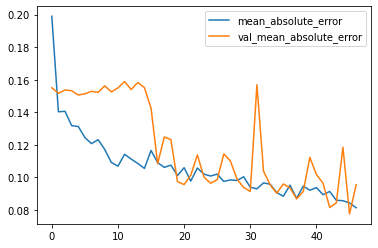

Epoch 48/60
35/35 [==============================] - 258s 7s/step - loss: 0.0122 - mean_absolute_error: 0.0843 - val_loss: 0.0119 - val_mean_absolute_error: 0.0777

Epoch 00048: val_mean_absolute_error did not improve from 0.07744


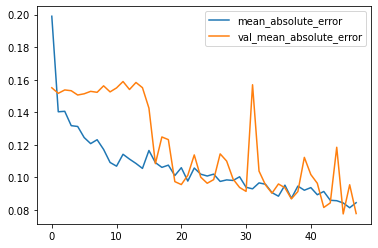

Epoch 49/60
35/35 [==============================] - 260s 7s/step - loss: 0.0117 - mean_absolute_error: 0.0831 - val_loss: 0.0113 - val_mean_absolute_error: 0.0751

Epoch 00049: val_mean_absolute_error improved from 0.07744 to 0.07509, saving model to meat_best.h5


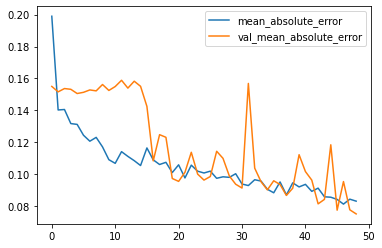

Epoch 50/60
35/35 [==============================] - 261s 7s/step - loss: 0.0129 - mean_absolute_error: 0.0833 - val_loss: 0.0146 - val_mean_absolute_error: 0.0837

Epoch 00050: val_mean_absolute_error did not improve from 0.07509


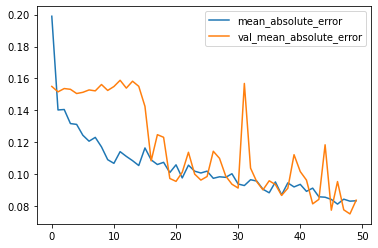

Epoch 51/60
35/35 [==============================] - 256s 7s/step - loss: 0.0127 - mean_absolute_error: 0.0820 - val_loss: 0.0209 - val_mean_absolute_error: 0.0991

Epoch 00051: val_mean_absolute_error did not improve from 0.07509


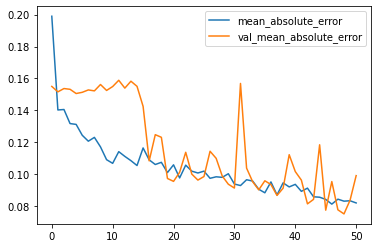

Epoch 52/60
35/35 [==============================] - 260s 7s/step - loss: 0.0116 - mean_absolute_error: 0.0824 - val_loss: 0.0205 - val_mean_absolute_error: 0.0990

Epoch 00052: val_mean_absolute_error did not improve from 0.07509


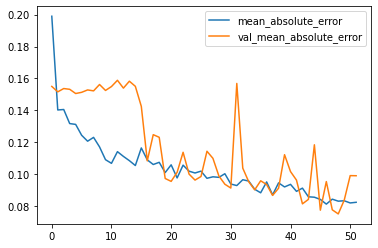

Epoch 53/60
35/35 [==============================] - 261s 7s/step - loss: 0.0124 - mean_absolute_error: 0.0834 - val_loss: 0.0344 - val_mean_absolute_error: 0.1208

Epoch 00053: val_mean_absolute_error did not improve from 0.07509


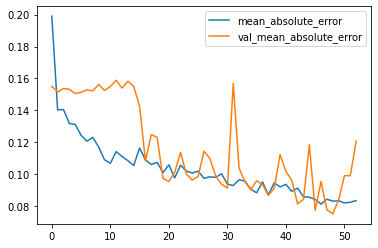

Epoch 54/60
35/35 [==============================] - 260s 7s/step - loss: 0.0112 - mean_absolute_error: 0.0787 - val_loss: 0.0213 - val_mean_absolute_error: 0.1002

Epoch 00054: val_mean_absolute_error did not improve from 0.07509


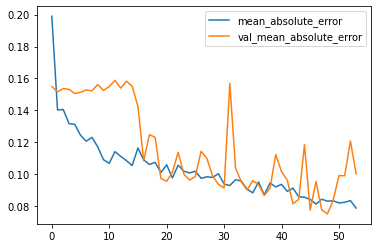

Epoch 55/60
35/35 [==============================] - 258s 7s/step - loss: 0.0105 - mean_absolute_error: 0.0779 - val_loss: 0.0124 - val_mean_absolute_error: 0.0770

Epoch 00055: val_mean_absolute_error did not improve from 0.07509


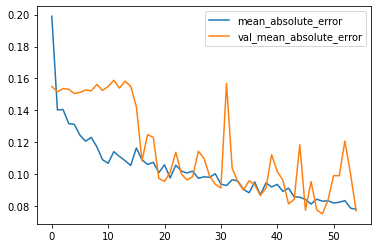

Epoch 56/60
35/35 [==============================] - 261s 7s/step - loss: 0.0117 - mean_absolute_error: 0.0811 - val_loss: 0.0120 - val_mean_absolute_error: 0.0782

Epoch 00056: val_mean_absolute_error did not improve from 0.07509


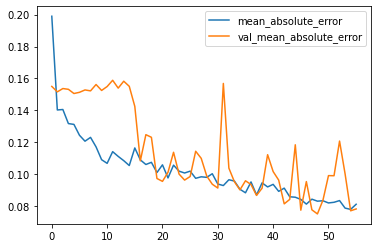

Epoch 57/60
35/35 [==============================] - 263s 8s/step - loss: 0.0106 - mean_absolute_error: 0.0783 - val_loss: 0.0168 - val_mean_absolute_error: 0.0877

Epoch 00057: val_mean_absolute_error did not improve from 0.07509


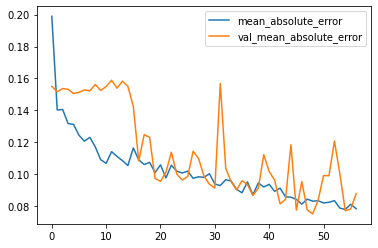

Epoch 58/60
35/35 [==============================] - 260s 7s/step - loss: 0.0094 - mean_absolute_error: 0.0728 - val_loss: 0.0152 - val_mean_absolute_error: 0.0852

Epoch 00058: val_mean_absolute_error did not improve from 0.07509


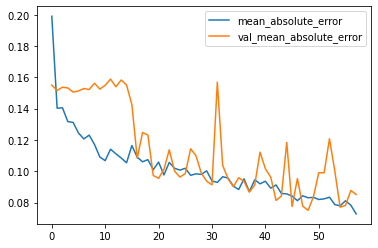

Epoch 59/60
35/35 [==============================] - 263s 8s/step - loss: 0.0111 - mean_absolute_error: 0.0797 - val_loss: 0.0264 - val_mean_absolute_error: 0.1060

Epoch 00059: val_mean_absolute_error did not improve from 0.07509


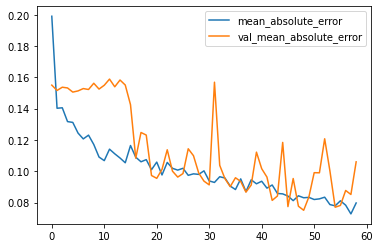

Epoch 60/60
35/35 [==============================] - 261s 7s/step - loss: 0.0099 - mean_absolute_error: 0.0746 - val_loss: 0.0144 - val_mean_absolute_error: 0.0836

Epoch 00060: val_mean_absolute_error did not improve from 0.07509


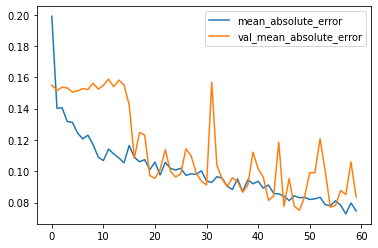

/opt/conda/lib/python3.7/site-packages/keras/engine/training.py:2006: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  warnings.warn('`Model.evaluate_generator` is deprecated and '


score (mse, mae):
 [0.010269553400576115, 0.07274128496646881]


/opt/conda/lib/python3.7/site-packages/keras/engine/training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


prediction:
 [[0.10637245]
 [0.14220968]
 [0.06663147]
 [0.19949731]
 [0.03030664]
 [0.87913734]
 [0.04400414]
 [0.27198467]
 [0.90236735]
 [0.0647631 ]
 [0.04663235]
 [0.2708577 ]
 [0.04306254]
 [0.04298902]
 [0.07533661]
 [0.03354073]
 [0.07343996]
 [0.21579787]
 [0.7456219 ]
 [0.0343301 ]
 [0.19479522]
 [0.85988796]
 [0.03773499]
 [0.20427296]
 [0.0491164 ]
 [0.03554124]
 [0.6863989 ]
 [0.10740668]
 [0.15646288]
 [0.10714021]
 [0.1332801 ]
 [0.8780986 ]
 [0.58498377]
 [0.02956334]
 [0.10497537]
 [0.05302221]
 [0.10713601]
 [0.03444609]
 [0.05619019]
 [0.07038739]
 [0.82737386]
 [0.12279263]
 [0.13693595]
 [0.02875954]
 [0.03752545]
 [0.41708001]
 [0.28149045]
 [0.61610574]
 [0.32311368]
 [0.04620025]
 [0.14934808]
 [0.35753918]
 [0.25388473]
 [0.06356391]
 [0.0829609 ]
 [0.02860355]
 [0.0837968 ]
 [0.09718052]
 [0.07015145]
 [0.12136447]
 [0.26480088]
 [0.05416462]
 [0.03686488]
 [0.08244205]
 [0.20407954]
 [0.04809022]
 [0.6112876 ]
 [0.23244104]
 [0.03559348]
 [0.04714742]
 [0.169

In [4]:
from keras.models import Model, load_model
from keras.layers import Dense, Dropout, Flatten, Input, BatchNormalization, Conv2D, MaxPool2D
from tensorflow.keras.optimizers import Adam
from keras_preprocessing.image import ImageDataGenerator
from keras.callbacks import Callback, ModelCheckpoint
import matplotlib.pyplot as plt
import pandas as pd


BATCH_SIZE = 20
IMAGE_SIZE = (256,256)


dataframe = pd.read_csv('contest_foodweight/adj_fried_noodles_dataset.csv', delimiter=',', header=0)


#https://keras.io/api/preprocessing/image/
#https://machinelearningmastery.com/how-to-configure-image-data-augmentation-when-training-deep-learning-neural-networks/
datagen = ImageDataGenerator(
            rescale=1./255,
            brightness_range=[0.9,1.1],
            shear_range=1,
            zoom_range=0.05,
            rotation_range=10,
            width_shift_range=0.03,
            height_shift_range=0.03,
            vertical_flip=True,
            horizontal_flip=True)

datagen_noaug = ImageDataGenerator(rescale=1./255)

train_generator = datagen.flow_from_dataframe(
    dataframe=dataframe.loc[0:699],
    directory='contest_foodweight/images',
    x_col='filename',
    y_col='norm_meat',
    shuffle=True,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='other')

validation_generator = datagen_noaug.flow_from_dataframe(
    dataframe=dataframe.loc[700:1399],
    directory='contest_foodweight/images',
    x_col='filename',
    y_col='norm_meat',
    shuffle=False,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='other')

test_generator = datagen_noaug.flow_from_dataframe(
    dataframe=dataframe.loc[1400:1856],
    directory='contest_foodweight/images',
    x_col='filename',
    y_col='norm_meat',
    shuffle=False,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='other')

inputIm = Input(shape = (IMAGE_SIZE[0],IMAGE_SIZE[1],3,))
conv1 = Conv2D(64,3,activation='relu')(inputIm)
conv1 = Conv2D(64,3,activation='relu')(conv1)
conv1 = BatchNormalization()(conv1)
pool1 = MaxPool2D()(conv1)
conv2 = Conv2D(128,3,activation='relu')(pool1)
conv2 = Conv2D(128,3,activation='relu')(conv2)
conv2 = BatchNormalization()(conv2)
pool2 = MaxPool2D()(conv2)
conv3 = Conv2D(256,3,activation='relu')(pool2)
conv3 = Conv2D(256,3,activation='relu')(conv3)
conv3 = BatchNormalization()(conv3)
pool3 = MaxPool2D()(conv3)
conv4 = Conv2D(512,3,activation='relu')(pool3)
conv4 = Conv2D(512,3,activation='relu')(conv4)
conv4 = BatchNormalization()(conv4)
pool4 = MaxPool2D()(conv4)
conv5 = Conv2D(1024,3,activation='relu')(pool4)
conv5 = Conv2D(1024,3,activation='relu')(conv5)
conv5 = BatchNormalization()(conv5)
pool5 = MaxPool2D()(conv5)
flat = Flatten()(pool5)
dense1 = Dense(512,activation='sigmoid')(flat)
dense1 = Dropout(0.5)(dense1)
dense1 = Dense(512,activation='sigmoid')(dense1)
dense1 = Dropout(0.5)(dense1)
dense1 = Dense(512,activation='sigmoid')(dense1)
dense1 = Dropout(0.5)(dense1)
predictedW = Dense(1,activation='sigmoid')(dense1)

model = Model(inputs=inputIm, outputs=predictedW)

model.compile(optimizer=Adam(lr = 1e-4), loss='mse', metrics=['mean_absolute_error'])


class PlotLosses(Callback):
    def on_train_begin(self, logs={}):
        self.x = []
        self.losses = []
        self.val_losses = []
        self.fig = plt.figure()
        self.logs = []

    def on_epoch_end(self, epoch, logs={}):
        self.logs.append(logs)
        self.x.append(epoch)
        self.losses.append(logs.get('mean_absolute_error'))
        self.val_losses.append(logs.get('val_mean_absolute_error'))

        plt.clf()
        plt.plot(self.x, self.losses, label='mean_absolute_error')
        plt.plot(self.x, self.val_losses, label='val_mean_absolute_error')
        plt.legend()
        plt.pause(0.01)


checkpoint = ModelCheckpoint('meat_best.h5', verbose=1, monitor='val_mean_absolute_error',save_best_only=True, mode='min')
plot_losses = PlotLosses()

#Train Model
model.fit_generator(
    train_generator,
    steps_per_epoch= len(train_generator),
    epochs=60,
    validation_data=validation_generator,
    validation_steps= len(validation_generator),
    callbacks=[checkpoint, plot_losses])


#Test Model
model = load_model('meat_best.h5')
score = model.evaluate_generator(
    test_generator,
    steps=len(test_generator))
print('score (mse, mae):\n',score)

test_generator.reset()
predict = model.predict_generator(
    test_generator,
    steps=len(test_generator),
    workers = 1,
    use_multiprocessing=False)
print('prediction:\n',predict)


